# Computer vision

> Using the fastai library in computer vision.

In [ ]:
from fastai2.vision.all import *

In [ ]:
# all_slow

This tutorial highlights on how to quickly build a `Learner` and fine tune a pretrained model on most computer vision tasks. 

## Single-label classification

For this task, we will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) that contains images of cats and dogs of 37 different breeds. We will first show how to build a simple cat-vs-dog classifier, then a little bit more advanced model that can classify all breeds.

The dataset can be downloaded and decompressed with this line of code:

In [ ]:
path = untar_data(URLs.PETS)

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the `.ls()` method.

In [ ]:
path.ls()

(#3) [Path('/home/ashwin/.fastai/data/oxford-iiit-pet/images'),Path('/home/ashwin/.fastai/data/oxford-iiit-pet/models'),Path('/home/ashwin/.fastai/data/oxford-iiit-pet/annotations')]

We will ignore the annotations folder for now, and focus on the images one. `get_image_files` is a fastai function that helps us grab all the image files (recursively) in one folder.

In [ ]:
files = get_image_files(path/"images")
len(files)

7390

### Cats vs dogs

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs:

In [ ]:
files[0],files[6]

(Path('/home/ashwin/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_102.jpg'),
 Path('/home/ashwin/.fastai/data/oxford-iiit-pet/images/great_pyrenees_102.jpg'))

We can then define an easy label function:

In [ ]:
def label_func(f): return f[0].isupper()

To get our data ready for a model, we need to put it in a `DataLoaders` object. Here we have a function that labels using the file names, so we will use `ImageDataLoaders.from_name_func`. There are other factory methods of `ImageDataLoaders` that could be more suitable for your problem, so make sure to check them all in `vision.data`. 

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we're working in, the `files` we grabbed, our `label_func` and one last piece as `item_tfms`: this is a `Transform` applied on all items of our dataset that will resize each imge to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn't pass this, we would get an error later as it would be impossible to batch the items together.

We can then check if everything looks okay with the `show_batch` method (`True` is for cat, `False` is for dog):

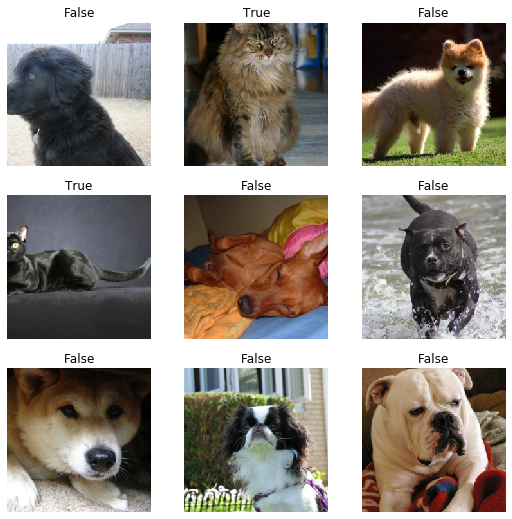

In [ ]:
dls.show_batch()

Then we can create a `Learner`, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

The first line downloaded a model called ResNet34, pretrained on [ImageNet](http://www.image-net.org/), and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with an error rate of 0.3%... amazing!

If you want to make a prediction on a new image, you can use `learn.predict`:

In [ ]:
learn.predict(files[0])

('False', tensor(0), tensor([9.9970e-01, 2.9784e-04]))

The predict method returns three things: the decoded prediction (here `False` for dog), the index of the predicted class and the tensor of probabilities that our image is one of a dog (here the model is quite confident!) This method accepts a filename, a PIL image or a tensor directly in this case.

We can also have a look at some predictions with the `show_results` method:

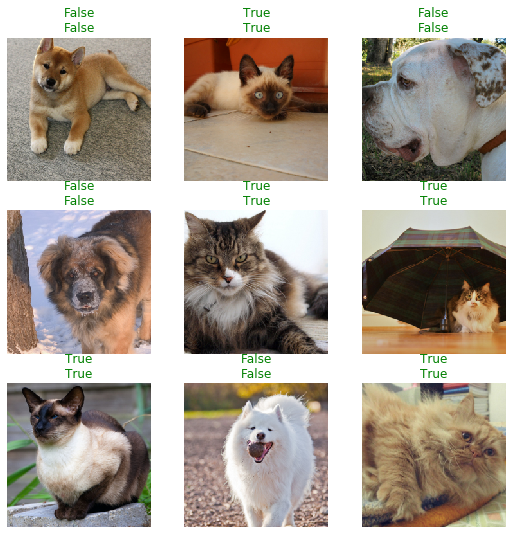

In [ ]:
learn.show_results()

Check out the other applications like text or tabular, or the other problems covered in this tutorial, and you will see they all share a consistent API for gathering the data and look at it, create a `Learner`, train the model and look at some predictions.

### Classifying breeds

To label our data with the breed name, we will use a regular expression to exctract it from the filename. Looking back at a filename, we have:

In [ ]:
files[0].name

'yorkshire_terrier_187.jpg'

so the class is everything before the last `_` followed by some digits. A regular expression that will catch the name is thus:

In [ ]:
pat = r'^(.*)_\d+.jpg'

Since it's pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

Like before, we can then use `show_batch` to have a look at our data:

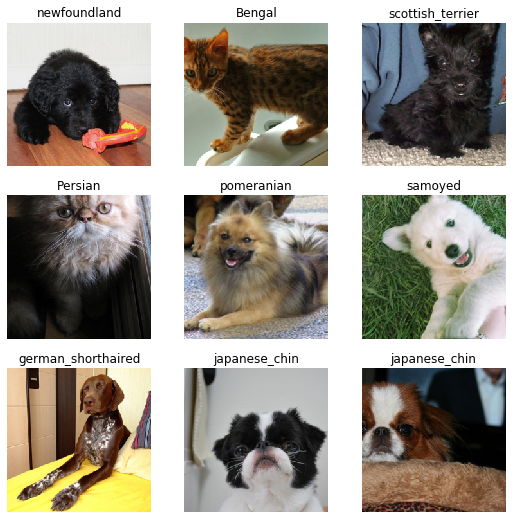

In [ ]:
dls.show_batch()

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our `DataLoaders` to use data augmentation:

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

This time we resized to a larger size before batching, and we add `batch_tfms`. `aug_transforms` is a function that provides a collection of data augmentation transforms with defaults we found worked very well on most datasets (you can customize each one by passing the right arguments).

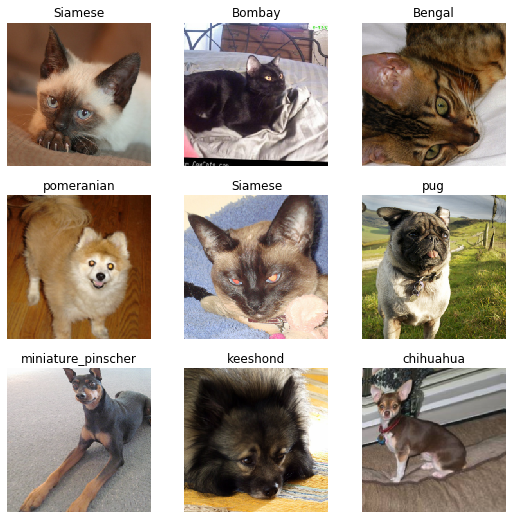

In [ ]:
dls.show_batch()

We can then create our `Learner` exactly as before and train our model.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

We used the default learning rate before, but we might want to find the best one possible. For this, we can use the learning rate finder:

(0.010000000149011612, 0.00363078061491251)

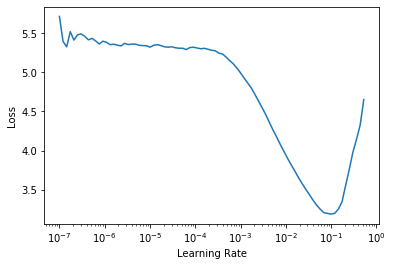

In [ ]:
learn.lr_find()

It plots the graph of the learning rate finder and gives us two suggestions (minimum divided by 10 and steepest gradient). Let's use `3e-3` here. We will also do a bit more epochs:

In [ ]:
learn.fine_tune(4, 3e-3)

Again, we can have a look at some predictions with `show_results`:

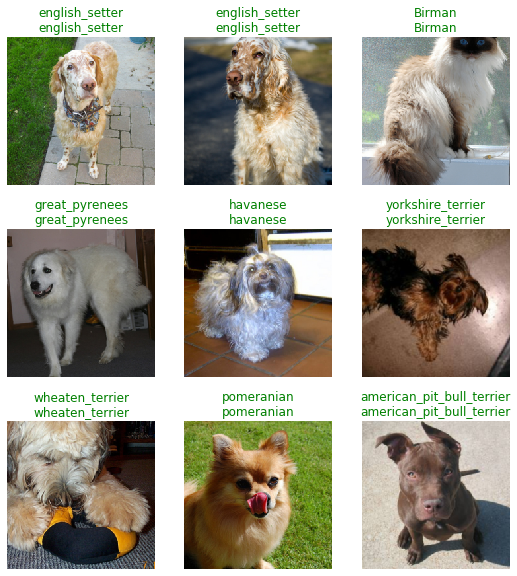

In [ ]:
learn.show_results()

Another thing that is useful is an interpretation object, it can show us where the model made the worse predictions:

In [ ]:
interp = Interpretation.from_learner(learn)

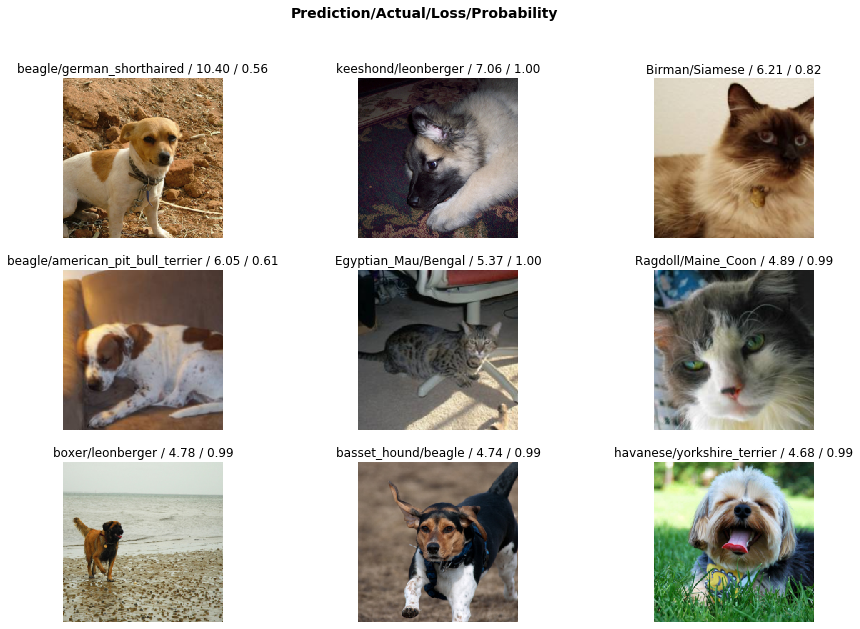

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

### With the data block API

We can also use the data block API to get our data in a `DataLoaders`. This is a bit more advanced, so fell free to skip this part if you are not comfortable with learning new API's just yet.

A datablock is built by giving the fastai library a bunch of informations:

- the types used, through an argument called `blocks`: here we have images and categories, so we pass `ImageBlock` and `CategoryBlock`.
- how to get the raw items, here our function `get_image_files`.
- how to label those items, here with the same regular expression as before.
- how to split those items, here with a random splitter.
- the `item_tfms` and `batch_tfms` like before.

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

The pets object by itself is empty: it only containes the functions that will help us gather the data. We have to call `dataloaders` method to get a `DataLoaders`. We pass it the source of the data:

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

Then we can look at some of our pictures with `dls.show_batch()`

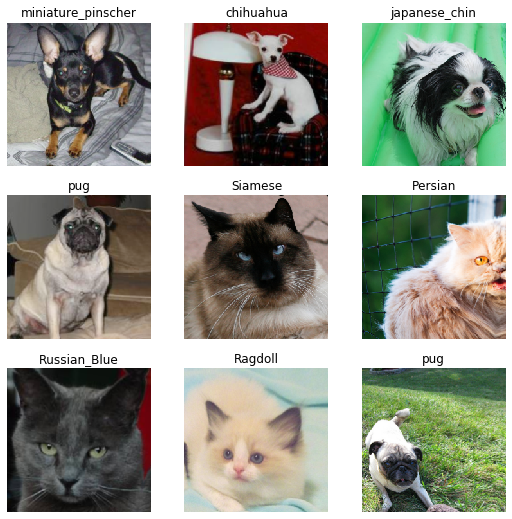

In [ ]:
dls.show_batch(max_n=9)

## Multi-label classification

For this task, we will use the [Pascal Dataset](http://host.robots.ox.ac.uk/pascal/VOC/) that contains images with different kinds of objects/persons. It's orginally a dataset for object detection, meaning the task is not only to detect if there is an instance of one class of an image, but to also draw a bounding box around it. Here we will just try to predict all the classes in one given image.

Multi-label classification defers from before in the sense each image does not belong to one category. An image could have a person *and* a horse inside it for instance. Or have none of the categories we study.

As before, we can download the dataset pretty easily:

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#9) [Path('/home/ashwin/.fastai/data/pascal_2007/valid.json'),Path('/home/ashwin/.fastai/data/pascal_2007/segmentation'),Path('/home/ashwin/.fastai/data/pascal_2007/train.csv'),Path('/home/ashwin/.fastai/data/pascal_2007/test.csv'),Path('/home/ashwin/.fastai/data/pascal_2007/models'),Path('/home/ashwin/.fastai/data/pascal_2007/test'),Path('/home/ashwin/.fastai/data/pascal_2007/train.json'),Path('/home/ashwin/.fastai/data/pascal_2007/train'),Path('/home/ashwin/.fastai/data/pascal_2007/test.json')]

The information about the labels of each image is in the file named `train.csv`. We load it using pandas:

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

### Using the high-level API

That's pretty straightforward: for each filename, we get the different labels (separated by space) and the last column tells if it's in the validation set or not. To get this in `DataLoaders` quickly, we have a factory method, `from_df`. We can specify the underlying path where all the images are, an additional folder to add between the base path and the filenames (here `train`), the `valid_col` to consider for the validation set (if we don't specify this, we take a random subset), a `label_delim` to split the labels and, as before, `item_tfms` and `batch_tfms`.

Note that we don't have to specify the `fn_col` and the `label_col` because they default to the first and second column respectively.

In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

As before, we can then have a look at the data with the `show_batch` method.

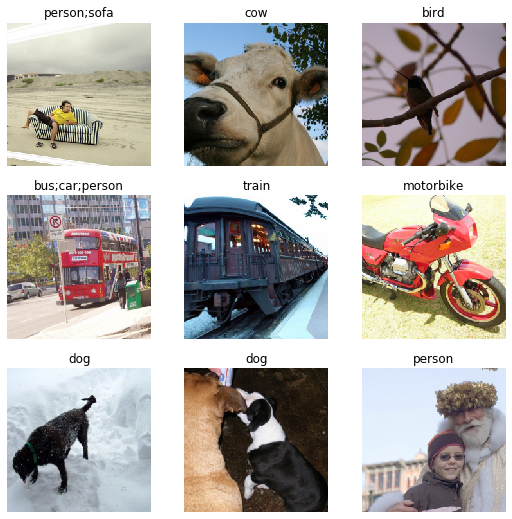

In [ ]:
dls.show_batch()

Training a model is as easy as before: the same functions can be applied and the fastai library will automatically detect that we are in a multi-label problem, thus picking the right loss function. The only difference is in the metric we pass: `error_rate` will not work for a multi-label problem, but we can use `accuracy_thresh`.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

As before, we can use `learn.lr_find` to pick a good learning rate:

(0.025118863582611083, 0.033113110810518265)

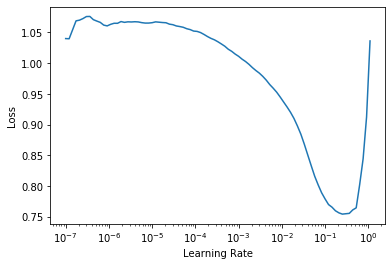

In [ ]:
learn.lr_find()

We can pick the suggested learning rate and fine-tune our pretrained model:

In [ ]:
learn.fine_tune(4, 3e-2)

Like before, we can easily have a look at the results:

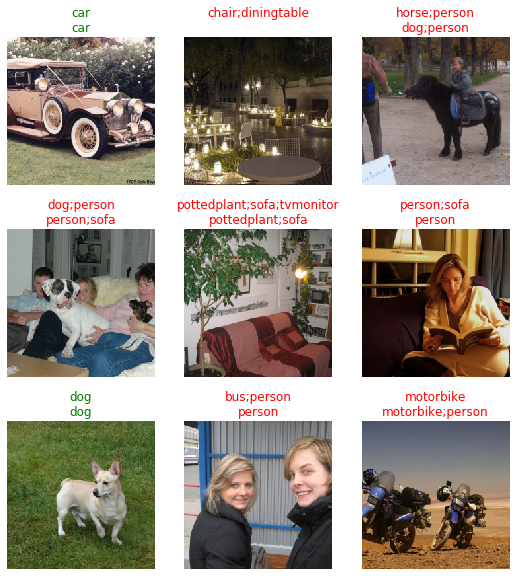

In [ ]:
learn.show_results()

Or get the predictions on a given image:

In [ ]:
learn.predict(path/'train/000005.jpg')

((#1) ['chair'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([6.0259e-05, 6.2471e-04, 2.9542e-04, 3.7423e-04, 3.9715e-02, 1.9572e-03,
         7.3608e-04, 1.7575e-02, 9.2661e-01, 6.8919e-04, 4.9777e-01, 1.2133e-02,
         1.1415e-03, 1.6763e-03, 1.2275e-01, 7.3525e-02, 5.6224e-04, 2.1502e-01,
         1.7034e-03, 1.4736e-01]))

As for the single classification predictions, we get three things. The last one is the prediction of the model on each class (going from 0 to 1). The second to last cooresponds to a one-hot encoded targets (you get `True` for all predicted classes, the ones that get a probability > 0.5) and the first is the decoded, readable version.

And like before, we can check where the model did its worse:

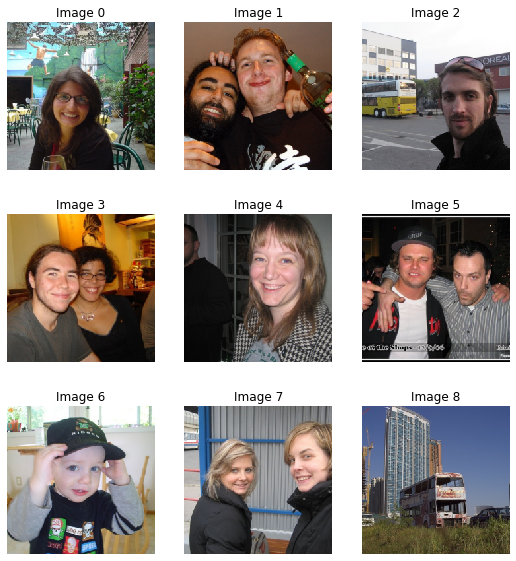

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

### With the data block API

We can also use the data block API to get our data in a `DataLoaders`. Like we said before, feel free to skip this part if you are not comfortable with learning new APIs just yet.

Remember how the data is structured in our dataframe:

In [ ]:
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

In this case we build the data block by providing:

- the types used: `ImageBlock` and `MultiCategoryBlock`.
- how to get the input items from our dataframe: here we read the column `fname` and need to add path/train/ at the beginning to get proper filenames.
- how to get the targets from our dataframe: here we read the column `labels` and need to split by space.
- how to split the items, here by using the column `is_valid`.
- the `item_tfms` and `batch_tfms` like before.

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

This block is slightly different than before: we don't need to pass a function to gather all our items as the dataframe we will give already has them all. However, we do need to preprocess the row of that dataframe to get out inputs, which is why we pass a `get_x`. It defaults to the fastai function `noop`, which is why we didn't need to pass it along before.

Like before, `pascal` is just a blueprint. We need to pass it the source of our data to be able to get `DataLoaders`:

In [ ]:
dls = pascal.dataloaders(df)

Then we can look at some of our pictures with `dls.show_batch()`

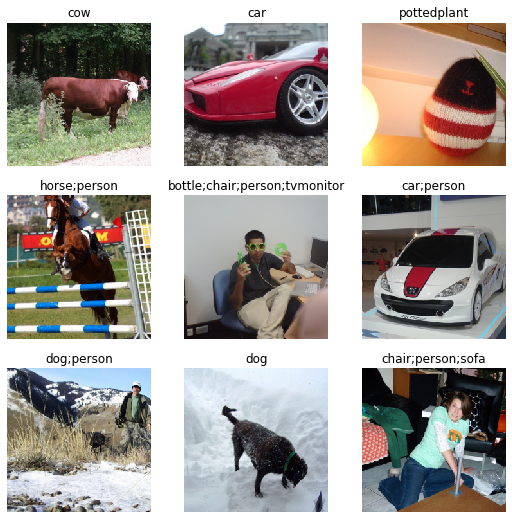

In [ ]:
dls.show_batch(max_n=9)

## Segmentation

Segmentation is a problem where we have to predict a category for each pixel of the image. For this task, we will use the [Camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/), a dataset of screenshots from cameras in cars. Each pixel of the image has a label such as "road", "car" or "pedestrian".

As usual, we can download the data with our `untar_data` function.

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#5) [Path('/home/sgugger/.fastai/data/camvid_tiny/codes.txt'),Path('/home/sgugger/.fastai/data/camvid_tiny/labels'),Path('/home/sgugger/.fastai/data/camvid_tiny/models'),Path('/home/sgugger/.fastai/data/camvid_tiny/export.pkl'),Path('/home/sgugger/.fastai/data/camvid_tiny/images')]

The `images` folder contains the images, and the corresponding segmentation masks of labels are in the `labels` folder. The `codes` file contains the corresponding integer to class (the masks have an int value for each pixel). 

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Using the high-level API

As before, the `get_image_files` function helps us grab all the image filenames:

In [ ]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/home/sgugger/.fastai/data/camvid_tiny/images/0016E5_05310.png')

Let's have a look in the labels folder:

In [ ]:
(path/"labels").ls()[0]

Path('/home/sgugger/.fastai/data/camvid_tiny/labels/0016E5_00840_P.png')

It seems the segmentation masks have the same base names as the images but with an extra `_P`, so we can define a label function: 

In [ ]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

We can then gather our data using `SegmentationDataLoaders`:

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

We do not need to pass `item_tfms` to resize our images here because they already are all of the same size.

As usual, we can have a look at our data with the `show_batch` method. In this instance, the fastai library is superimposing the masks with one specific color per pixel:

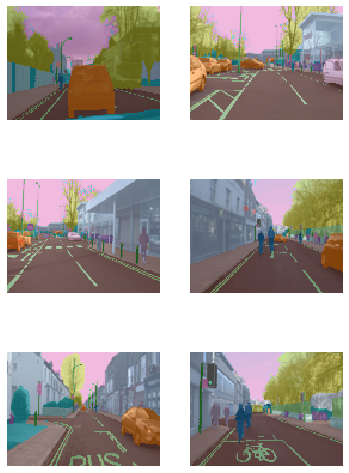

In [ ]:
dls.show_batch(max_n=6)

A traditional CNN won't work for segmentation, we have to use a special kind of model called a UNet, so we use `unet_learner` to define our `Learner`:

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

And as before, we can get some idea of the predicted results with `show_results`

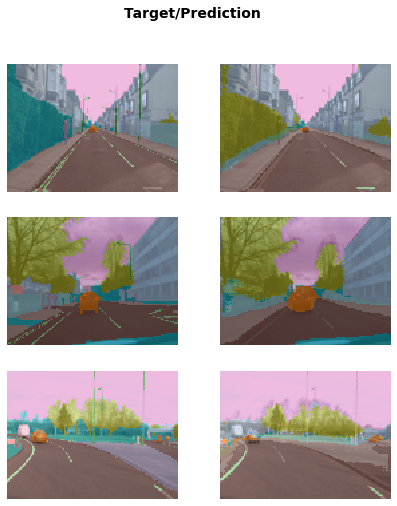

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

### With the data block API

We can also use the data block API to get our data in a `DataLoaders`. Like it's been said before, feel free to skip this part if you are not comfortable with learning new APIs just yet.

In this case we build the data block by providing:

- the types used: `ImageBlock` and `MaskBlock`. We provide the `codes` to `MaskBlock` as there is no way to guess them from the data.
- how to gather our items, here by using `get_image_files`.
- how to get the targets from our items: by using `label_func`.
- how to split the items, here randomly.
- `batch_tfms` for data augmentation.

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [ ]:
dls = camvid.dataloaders(path/"images", path=path, bs=8)

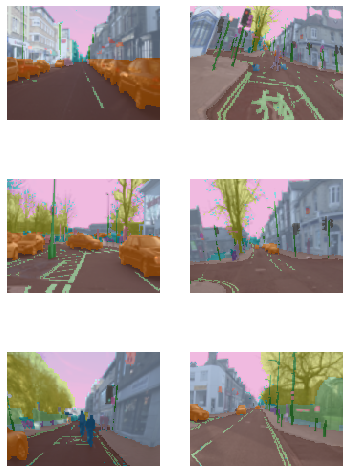

In [ ]:
dls.show_batch(max_n=6)

## Points

This section uses the data block API, so if you skipped it before, we recommend you skip this section as well.

We will now look at a task where we want to predict points in a picture. For this, we will use the [Biwi Kinect Head Pose Dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db). First thing first, let's begin by downloading the dataset as usual.

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

Let's see what we've got!

In [ ]:
path.ls()

(#50) [Path('/home/sgugger/.fastai/data/biwi_head_pose/01.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/18.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/04'),Path('/home/sgugger/.fastai/data/biwi_head_pose/10.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/24'),Path('/home/sgugger/.fastai/data/biwi_head_pose/14.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/20.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/11.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/02.obj'),Path('/home/sgugger/.fastai/data/biwi_head_pose/07')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different persons photographed) and a corresponding .obj file (we won't need them here). We'll take a look inside one of these directories:

In [ ]:
(path/'01').ls()

(#1000) [Path('01/frame_00087_pose.txt'),Path('01/frame_00079_pose.txt'),Path('01/frame_00114_pose.txt'),Path('01/frame_00084_rgb.jpg'),Path('01/frame_00433_pose.txt'),Path('01/frame_00323_rgb.jpg'),Path('01/frame_00428_rgb.jpg'),Path('01/frame_00373_pose.txt'),Path('01/frame_00188_rgb.jpg'),Path('01/frame_00354_rgb.jpg')...]

Inside the subdirectories, we have different frames, each of them come with an image (`\_rgb.jpg`) and a pose file (`\_pose.txt`). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file.

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('04/frame_00084_pose.txt')

We can have a look at our first image:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

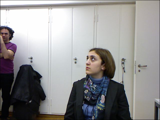

In [ ]:
im.to_thumb(160)

The Biwi dataset web site explains the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

tensor([372.4046, 245.8602])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same person appears in multiple images in this dataset — but we want to ensure that our model can generalise to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function which returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference to previous data block examples is that the second block is a `PointBlock`. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images.

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

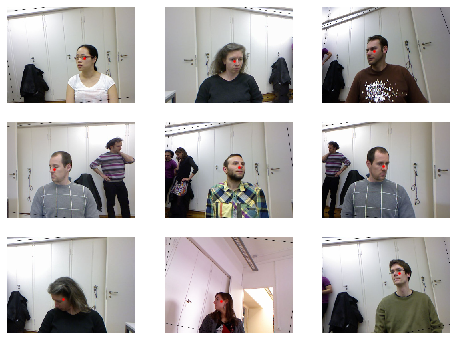

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

Now that we have assembled our data, we can use the rest of the fastai API as usual. `cnn_learner` works perfectly in this case, and the library will infer the proper loss function from the data:

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

(0.005754399299621582, 3.6307804407442745e-07)

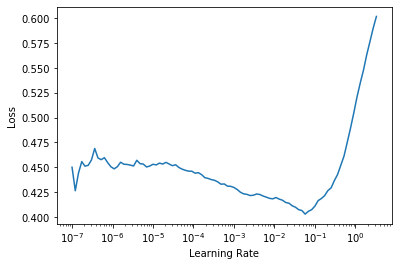

In [ ]:
learn.lr_find()

Then we can train our model:

In [ ]:
learn.fine_tune(4, 5e-3)

The loss is the mean squared error, so that means we make on average an error of 

In [ ]:
math.sqrt(0.0001)

0.01

percent when predicting our points! And we can look at those results as usual:

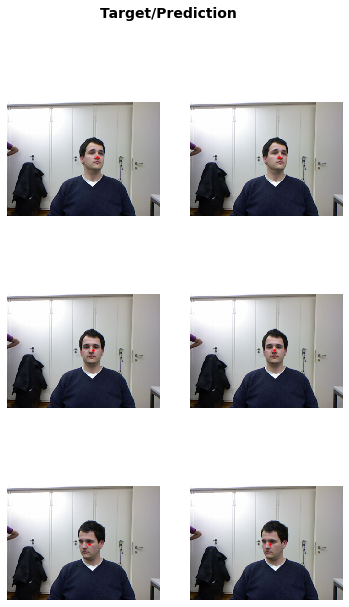

In [ ]:
learn.show_results()